In [13]:
import argparse
import os
import shutil
import time
import math
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data as data_utils
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import cv2

# Model Defination 

In [30]:
"""
ResNet defination: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

"""


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class G_model(nn.Module):

    def __init__(self, block, layers, num_common_blocks=4, num_albedo_blocks=4, num_shading_blocks=4, num_classes=1000):
        """
            resnet18 begin
        """ 
        self.inplanes = 64
        super(G_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
#         self.avgpool = nn.AvgPool2d(7)
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        """
            resnet18 end
        """
        
#         self.myfc = nn.Linear(num_classes, 2)
        """
            input data
        """
            
        """
            conv or upsample to 8M:
            from maxpool output(8M) and layer3 output(M)
        """
        self.num_common_channels = 64
        self.upsample1 = nn.Conv2d(64, self.num_common_channels, kernel_size=5, padding=2, bias=False)
        self.upsample1_bn = nn.BatchNorm2d(self.num_common_channels)
        self.upsample1_relu = nn.ReLU(inplace=True)
        
        self.upsample2 = nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1, bias=False)
        self.upsample2_conv = nn.Conv2d(256, self.num_common_channels, kernel_size=5, padding=2, bias=False)
        self.upsample2_bn = nn.BatchNorm2d(self.num_common_channels)
        self.upsample2_relu = nn.ReLU(inplace=True)
        
        """
            intrinsic net: common part
        """
        self.common_layer = self._make_layer(block, self.num_common_channels, num_common_blocks)
        
        """
            albedo part
        """
        self.albedo_layer = self._make_layer(block, self.num_common_channels, num_albedo_blocks)
        self.albedo_output = nn.ConvTranspose2d(self.num_common_channels, 3, kernel_size=8, padding=4, bias=True)
        
        """
            shading part
        """
        self.shading_layer = self._make_layer(block, self.num_common_channels, num_shading_blocks)
        self.shading_output = nn.ConvTranspose2d(self.num_common_channels, 3, kernel_size=8, padding=4, bias=True)
        

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        """
            resnet18 begin
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         x = self.myfc(x)

        """
            resnet18 end
        """

        """
            finetune part
                albedo
                shading
        """
        x = self.common_layer(x)
        albedo = self.albedo_layer(x)
        shading = self.shading_layer(x)
        albedo = self.albedo_output(albedo)
        shading = self.shading_output(shading)
        
        return albedo, shading
    
    
class D_model(nn.Module):
    def __init__(self):
        self.conv1 = nn.Conv2d(64, self.num_common_channels, kernel_size=5, padding=2, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d(128, self.num_common_channels, kernel_size=5, padding=2, bias=False)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv3 = nn.Conv2d(256, self.num_common_channels, kernel_size=5, padding=2, bias=False)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv4 = nn.Conv2d(256, self.num_common_channels, kernel_size=5, padding=2, bias=False)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv5 = nn.Conv2d(512, self.num_common_channels, kernel_size=5, padding=2, bias=False)
        self.relu5 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.fc = nn.Linear(256//32, 1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
    
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
    
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)
        
        x = self.fc(x)
        
        return x
    


pretrained_dict = torch.load('/Users/albertxavier/.torch/models/resnet18-5c106cde.pth')

G = G_model(BasicBlock, [2, 2, 2, 2])
G_dict = G.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in G_dict}
# 2. overwrite entries in the existing state dict
G_dict.update(pretrained_dict) 
# 3. load the new state dict
G.load_state_dict(pretrained_dict)

D = D_model()

KeyError: 'missing keys in state_dict: "set([\'upsample1_bn.running_var\', \'shading_layer.1.bn2.running_mean\', \'common_layer.0.downsample.0.weight\', \'common_layer.0.bn1.running_var\', \'shading_layer.1.bn1.running_mean\', \'common_layer.1.bn1.running_var\', \'common_layer.3.bn2.bias\', \'upsample1_bn.weight\', \'shading_layer.0.conv1.weight\', \'common_layer.1.bn2.running_var\', \'albedo_layer.2.bn2.running_mean\', \'shading_layer.1.bn1.running_var\', \'common_layer.3.bn1.running_var\', \'common_layer.0.downsample.1.running_var\', \'common_layer.0.conv2.weight\', \'albedo_layer.1.bn2.weight\', \'common_layer.3.conv1.weight\', \'shading_layer.2.bn2.bias\', \'shading_layer.2.bn1.running_mean\', \'common_layer.0.bn2.bias\', \'albedo_layer.2.bn2.weight\', \'albedo_layer.2.conv2.weight\', \'common_layer.3.conv2.weight\', \'albedo_layer.3.bn1.running_mean\', \'shading_layer.2.bn1.running_var\', \'shading_layer.2.bn2.running_var\', \'common_layer.1.bn2.running_mean\', \'albedo_layer.2.bn1.bias\', \'common_layer.2.bn1.weight\', \'albedo_layer.0.bn2.weight\', \'upsample1.weight\', \'common_layer.0.bn1.weight\', \'common_layer.0.downsample.1.running_mean\', \'shading_layer.2.conv1.weight\', \'albedo_layer.1.bn2.bias\', \'shading_layer.2.bn1.weight\', \'common_layer.0.downsample.1.weight\', \'common_layer.2.conv1.weight\', \'common_layer.2.bn2.weight\', \'shading_layer.3.conv1.weight\', \'common_layer.1.bn1.bias\', \'albedo_layer.1.bn1.weight\', \'albedo_layer.3.bn1.bias\', \'common_layer.0.bn2.running_var\', \'common_layer.1.conv2.weight\', \'albedo_output.weight\', \'shading_layer.3.bn2.weight\', \'upsample2_bn.bias\', \'albedo_layer.1.bn1.bias\', \'albedo_layer.2.bn1.running_var\', \'common_layer.1.bn1.weight\', \'shading_layer.0.bn1.running_mean\', \'common_layer.0.bn1.running_mean\', \'common_layer.3.bn1.bias\', \'shading_layer.2.bn2.weight\', \'common_layer.2.bn2.running_mean\', \'shading_layer.3.bn1.bias\', \'albedo_layer.1.bn1.running_mean\', \'common_layer.0.bn2.running_mean\', \'shading_layer.1.conv2.weight\', \'albedo_layer.1.bn2.running_mean\', \'common_layer.0.bn2.weight\', \'albedo_layer.0.conv1.weight\', \'common_layer.3.bn2.weight\', \'albedo_layer.0.bn2.running_var\', \'albedo_layer.0.bn1.running_var\', \'shading_layer.1.bn1.bias\', \'common_layer.0.downsample.1.bias\', \'common_layer.2.bn1.running_mean\', \'albedo_layer.0.bn2.running_mean\', \'shading_layer.3.conv2.weight\', \'shading_layer.1.bn2.running_var\', \'albedo_layer.3.conv1.weight\', \'shading_layer.3.bn1.running_mean\', \'upsample2_bn.running_mean\', \'common_layer.2.bn2.running_var\', \'common_layer.1.conv1.weight\', \'common_layer.2.bn1.running_var\', \'albedo_layer.0.bn1.weight\', \'common_layer.1.bn1.running_mean\', \'shading_layer.3.bn2.running_mean\', \'albedo_layer.3.bn2.running_var\', \'albedo_layer.2.bn2.running_var\', \'shading_layer.3.bn1.weight\', \'shading_layer.0.bn2.running_mean\', \'shading_layer.1.bn2.bias\', \'shading_layer.2.bn2.running_mean\', \'common_layer.2.conv2.weight\', \'shading_layer.0.bn1.bias\', \'upsample1_bn.bias\', \'albedo_layer.2.conv1.weight\', \'albedo_layer.0.bn2.bias\', \'upsample2_conv.weight\', \'shading_layer.0.bn2.weight\', \'albedo_layer.0.bn1.running_mean\', \'common_layer.3.bn1.running_mean\', \'albedo_layer.3.bn2.weight\', \'common_layer.3.bn1.weight\', \'albedo_layer.3.conv2.weight\', \'common_layer.2.bn2.bias\', \'albedo_layer.2.bn2.bias\', \'albedo_output.bias\', \'common_layer.3.bn2.running_var\', \'shading_layer.2.bn1.bias\', \'common_layer.1.bn2.weight\', \'common_layer.0.bn1.bias\', \'shading_layer.1.bn1.weight\', \'upsample2_bn.weight\', \'albedo_layer.0.conv2.weight\', \'common_layer.2.bn1.bias\', \'shading_output.weight\', \'upsample2.weight\', \'albedo_layer.1.bn1.running_var\', \'albedo_layer.0.bn1.bias\', \'albedo_layer.3.bn1.weight\', \'albedo_layer.1.bn2.running_var\', \'shading_layer.0.conv2.weight\', \'common_layer.1.bn2.bias\', \'albedo_layer.2.bn1.running_mean\', \'albedo_layer.1.conv1.weight\', \'common_layer.3.bn2.running_mean\', \'albedo_layer.3.bn1.running_var\', \'upsample1_bn.running_mean\', \'shading_layer.0.bn1.running_var\', \'albedo_layer.1.conv2.weight\', \'albedo_layer.3.bn2.running_mean\', \'shading_layer.0.bn1.weight\', \'shading_layer.0.bn2.running_var\', \'shading_layer.1.conv1.weight\', \'shading_layer.2.conv2.weight\', \'shading_layer.3.bn2.bias\', \'shading_output.bias\', \'shading_layer.3.bn2.running_var\', \'albedo_layer.2.bn1.weight\', \'albedo_layer.3.bn2.bias\', \'upsample2_bn.running_var\', \'shading_layer.3.bn1.running_var\', \'shading_layer.1.bn2.weight\', \'common_layer.0.conv1.weight\', \'shading_layer.0.bn2.bias\'])"'

# Load Pretrained Model 

In [16]:

# pretrained_resnet18 = torch.load('/Users/albertxavier/.torch/models/resnet18-5c106cde.pth')
# # print pretrained_resnet18
# pretrained_dict =  pretrained_resnet18.state_dict()

# G = G_model(BasicBlock, [2, 2, 2, 2])
# G_dict = G.state_dict()

# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in G_dict}
# # 2. overwrite entries in the existing state dict
# G_dict.update(pretrained_dict) 
# # 3. load the new state dict
# G_dict.load_state_dict(G_dict)

# D = D_model()





NameError: name 'D_model' is not defined

# Define Solver 

In [ ]:
lr = 0.01
criterion = nn.MSELoss();
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

dsdas
>>> i =  0


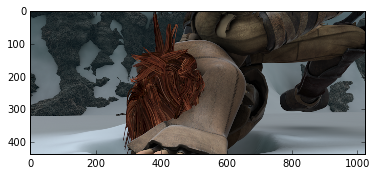

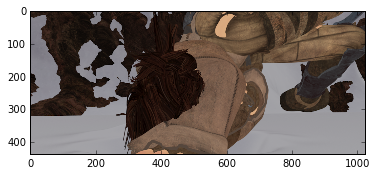

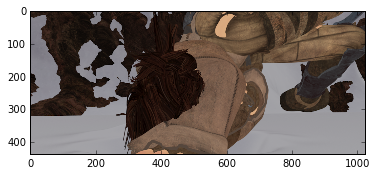

In [138]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import glob

%matplotlib inline

def default_loader(path):
    return Image.open(path).convert('RGB')

def make_dataset(dir):
    images_paths = glob.glob(os.path.join(dir, 'clean', '*', '*.png'))
    albedo_paths = images_paths[:]
    shading_paths = images_paths[:]
    pathes = []
    for img_path in images_paths:
        sp = img_path.split('/'); sp[-3] = 'albedo'; sp = ['/'] + sp; albedo_path = os.path.join(*sp)
        sp = img_path.split('/'); sp[-3] = 'albedo'; sp = ['/'] + sp; shading_path = os.path.join(*sp)
        pathes.append((img_path, albedo_path, shading_path))
    return pathes


class MyImageFolder(data_utils.Dataset):
    def __init__(self, root, transform=None, target_transform=None,
                loader=default_loader):
        print "dsdas"
        imgs = make_dataset(root)
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        
    def __getitem__(self, index):
        img_path, albedo_path, shading_path = self.imgs[index]
        
        img = self.loader(img_path)
        albedo = self.loader(albedo_path)
        shading = self.loader(shading_path)

        if self.transform is not None: img = self.transform(img)
        if self.transform is not None: albedo = self.transform(albedo)
        if self.transform is not None: shading = self.transform(shading)
#         if self.target_transform is not None:
#             target = self.target_transform(target)

        return img, albedo, shading
    
    def __len__(self):
        return len(self.imgs)

    
dataset= MyImageFolder('/Volumes/xavier/dataset/sintel/images/', 
                       transforms.Compose(
        [transforms.ToTensor()]
    ))
# print dataset.imgs[3]
# print dataset.imgs[4]
# print dataset.imgs[5]

dataloader=  data_utils.DataLoader(dataset,1,True,num_workers=1)
# print dataloader

# for i,(img,albedo,shading) in enumerate(dataloader):
#     print '>>> i = ', i
# #     print img
#     img = img.numpy(); img = np.array(img[0,:,:,:]); img = img.transpose(1,2,0); plt.imshow(img);
#     plt.figure(); albedo = albedo.numpy(); albedo = np.array(albedo[0,:,:,:]); albedo = albedo.transpose(1,2,0); plt.imshow(albedo);
#     plt.figure(); shading = shading.numpy(); shading = np.array(shading[0,:,:,:]); shading = shading.transpose(1,2,0); plt.imshow(shading);
#     break

In [ ]:
def train_discriminator(discriminator, predict, groundtruth):
    discriminator.zero_grad()
    outputs = D(groundtruth)
    real_loss = criterion(outputs, groundtruth)
    real_score = outputs
    
    outputs = discriminator(predict) 
    fake_loss = criterion(outputs, predict)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [ ]:
def train_generator(generator, discriminator_outputs, groundtruth):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, groundtruth)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [ ]:
"""
    Train
"""
epoches = 10
train_loader = dataloader
for epoch in range(num_epochs):
    for n, (img,ground_truth_albedo,ground_truth_shading) in enumerate(train_loader):
        img = Variable(img)
        real_label_albedo = Variable(ground_truth_albedo)
        predict_albedo, predict_shading = G(img)
        
        d_loss, real_score, fake_score = train_discriminator(D, predict_albedo, ground_truth_albedo)
        
        fake_image = G(img)
        output = discriminator(fake_image)
        
        g_loss = train_generator(G, output, ground_truth_albedo)
        
        if (n+1) % 100 == 0:
            test_albedo, _ = G(img)
            cv2.imwrite("test.png", test_albedo)

# Test Cells Below

# Custom Dataset Class

In [3]:
pretrained_resnet18 = models.resnet18(pretrained=True)
# print model.parameters
# print pretrained_resnet18
print pretrained_resnet18.state_dict()

OrderedDict([('conv1.weight', 
(0 ,0 ,.,.) = 
 -1.0419e-02 -6.1356e-03 -1.8098e-03  ...   5.6615e-02  1.7083e-02 -1.2694e-02
  1.1083e-02  9.5276e-03 -1.0993e-01  ...  -2.7124e-01 -1.2907e-01  3.7424e-03
 -6.9434e-03  5.9089e-02  2.9548e-01  ...   5.1972e-01  2.5632e-01  6.3573e-02
                 ...                   ⋱                   ...                
 -2.7535e-02  1.6045e-02  7.2595e-02  ...  -3.3285e-01 -4.2058e-01 -2.5781e-01
  3.0613e-02  4.0960e-02  6.2850e-02  ...   4.1384e-01  3.9359e-01  1.6606e-01
 -1.3736e-02 -3.6746e-03 -2.4084e-02  ...  -1.5070e-01 -8.2230e-02 -5.7828e-03

(0 ,1 ,.,.) = 
 -1.1397e-02 -2.6619e-02 -3.4641e-02  ...   3.2521e-02  6.6221e-04 -2.5743e-02
  4.5687e-02  3.3603e-02 -1.0453e-01  ...  -3.1253e-01 -1.6051e-01 -1.2826e-03
 -8.3730e-04  9.8420e-02  4.0210e-01  ...   7.0789e-01  3.6887e-01  1.2455e-01
                 ...                   ⋱                   ...                
 -5.5926e-02 -5.2239e-03  2.7081e-02  ...  -4.6178e-01 -5.7080e-01 -3

In [ ]:
"""
    Test image folder training datasets

    https://discuss.pytorch.org/t/questions-about-dataloader-and-dataset/806
    https://github.com/pytorch/examples/blob/master/imagenet/main.py

"""




In [ ]:

"""
    Test: load partial state dict
"""
model = G_model(BasicBlock, [2, 2, 2, 2])
pretrained_dict =  pretrained_resnet18.state_dict()
model_dict = model.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 

# print model_dict
# 3. load the new state dict
model.load_state_dict(model_dict)
# print model.state_dict()

# x = model.layer1[0].relu
# mynet = myNet(model)

# print mynet.conv1.weight
# print mynet.conv1.bias

In [125]:
loaded = torch.load('/Users/albertxavier/.torch/models/resnet18-5c106cde.pth')

del loaded[u'conv1.weight']
print loaded
mynet.load_state_dict(loaded)

print "after..............."
print mynet.conv1.weight
# print mynet.conv1.bias

OrderedDict([(u'bn1.running_mean', 
 2.7681e-03
-2.5769e-02
 2.1254e-07
-8.4605e-02
 2.1121e-08
 4.9691e-04
-2.2408e-02
-1.1582e-07
-4.8239e-03
 2.7507e-07
 3.9582e-02
 3.1994e-02
-3.7490e-02
-1.3716e-06
 6.6002e-03
 4.3782e-03
 6.4797e-02
 1.1176e-01
 3.6002e-02
-7.5075e-02
-3.8240e-02
 8.4358e-02
-5.2287e-02
-1.1799e-02
 1.3019e-03
 3.2172e-02
-1.7784e-02
-9.1009e-02
 1.1319e-01
-4.1632e-02
 8.7302e-03
 2.9693e-02
-7.0502e-02
-3.4847e-03
 1.0977e-01
-1.7341e-03
-5.9423e-08
 2.9330e-02
-7.8553e-09
 6.7320e-03
-3.7100e-03
 1.6028e-02
-2.7883e-02
 2.6593e-02
 2.8475e-02
-1.2735e-01
 4.4617e-02
 2.6329e-02
 2.1454e-08
-1.7045e-02
-3.5617e-03
-4.5841e-02
 6.3876e-02
 1.5220e-02
-3.8511e-02
-1.6428e-02
-1.6569e-02
 5.6057e-02
-8.0306e-02
-2.6646e-03
-4.1718e-02
 1.2611e-01
-4.9237e-02
-1.3261e-02
[torch.FloatTensor of size 64]
), (u'bn1.running_var', 
 1.0169e+00
 3.7167e+00
 5.8133e-11
 3.2825e+00
 1.7107e-13
 6.5823e-01
 4.3701e+00
 6.6005e-12
 9.1552e-01
 1.9318e-09
 4.1256e+00
 2.7440e

KeyError: 'unexpected key "layer3.0.conv1.weight" in state_dict'

In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [73]:
from graphviz import Digraph
from torch.autograd import Variable

def save(fname, creator):
    dot = Digraph(comment='LRP',
                node_attr={'style': 'filled', 'shape': 'box'})
    #, 'fillcolor': 'lightblue'})

    seen = set()

    def add_nodes(var):
        if var not in seen:
            if isinstance(var, Variable):
                dot.node(str(id(var)), str(var.size()), fillcolor='lightblue')
            else:
                dot.node(str(id(var)), type(var).__name__)
            seen.add(var)
            if hasattr(var, 'previous_functions'):
                for u in var.previous_functions:
                    dot.edge(str(id(u[0])), str(id(var)))
                    add_nodes(u[0])

    add_nodes(creator)
    dot.save(fname)
# dot.save(fname)
# print mymodel.creator
x = Variable(torch.rand(2,3,224,224))
out = mymodel(x)
save("./mynet.dot", out.creator)

RuntimeError: expected a Variable argument, but got ReLU